In [1]:
import pandas as pd
from nltk.corpus import stopwords
import nltk
import pymorphy2
import re
import string
from tqdm import tqdm
from collections import Counter
import numpy as np
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora
from datetime import datetime

tqdm.pandas()
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

from multiprocessing import Pool
morph = pymorphy2.MorphAnalyzer()

import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mchelushkin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Подготовка данных

In [2]:
commentsDF = pd.read_csv('data/commentsRAW.csv', usecols=['id', 'date', 'text'])
answersDF = pd.read_csv('data/answersRAW.csv', usecols=['id', 'date', 'text'])
commentsDF = commentsDF[commentsDF.text.notna()]
answersDF = answersDF[answersDF.text.notna()]

In [5]:
allCommentsDF = commentsDF.append(answersDF, ignore_index=True)
allCommentsDF.shape

(1433391, 3)

In [6]:
# вк собака объединяет символы - ковычки и троеточия
import emoji
def deEmojify(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r' ', text)

def give_emoji_free_text(text):
    return emoji.get_emoji_regexp().sub(r'', text)

punctuation = string.punctuation + '…«»—–'
def clean_text(text):
# Make text lowercase
    text = text.lower()
# remove text in square brackets
    text = re.sub(r'\[.*?\]', ' ', text)
# remove urls
    text = re.sub(r"http\S+", ' ', text)
# remove emojies
#     text = give_emoji_free_text(text)
# remove punctuation   
    text = re.sub(r'[%s]' % re.escape(punctuation), ' ', text)
# remove numbers
    text = re.sub(r'[0-9]', ' ', text)
# remove non letters
    text = re.sub(r'[^\w\s]', '', text)
# remove dublicate spaces
    text = re.sub('\s\s+', ' ', text)
    return text
comments_df_clean = pd.DataFrame(allCommentsDF.text.progress_apply(lambda x: clean_text(x)))

100%|██████████| 1433391/1433391 [00:55<00:00, 25985.99it/s]


In [7]:
%%time

stopwords_list = stopwords.words('russian') + stopwords.words('english')
stopwords_list.append('это')
stopwords_list.append('всё')
stopwords_list.append('ещё')
stopwords_list.append('весь')
stopwords_list.append('человек')
stopwords_list.append('свой')
stopwords_list.append('который')
stopwords_list.append('мочь')
stopwords_list.append('')

def lemmatize(text, lemmer = morph, stopwords = stopwords_list):
    words = text.split(' ')
    lemmas = [lemmer.parse(w)[0].normal_form for w in words]
    return [w for w in lemmas if len(w) >= 3 and not w in stopwords]

with Pool(processes = 4) as pool:
    lemmatized = pool.starmap(lemmatize, zip(comments_df_clean.text))

CPU times: user 10.4 s, sys: 9.48 s, total: 19.8 s
Wall time: 11min 49s


In [8]:
import json
with open('LDA/lemmatized.json', 'w') as f:
    f.write(json.dumps(lemmatized))

In [6]:
import json
with open('LDA/lemmatized.json', 'r') as f:
    lemmatized = json.loads(f.read())

In [8]:
# comments_lemmatized_df = pd.DataFrame({'text' : lemmatized, 'date' : allCommentsDF.date})
comments_lemmatized_df = pd.DataFrame({'text' : lemmatized, 'date' : allCommentsDF.date, 'raw_text':allCommentsDF.text})

In [9]:
def wordsCount(texts):
    count = Counter()
    for words in texts:
        for word in words:
            count[word] += 1
    return count

def removeNotCommonWords(text, word_counter):
    return [word for word in text if word_counter[word] > 10]

def func(df):
    word_counter = wordsCount(df.text.values.tolist())
    
    df.text = df.text.apply(lambda x: removeNotCommonWords(x, word_counter))
    df.text = df.text.apply(lambda x: ' '.join(x))
    df.text = df.text.apply(lambda x: x.split())
    df = df[df.text.apply(lambda x: len(x) >= 20 and len(x) <= 300)]
#     df = df[df.text.apply(lambda x: len(x) < 20)]
    return df
clean_texts = func(comments_lemmatized_df)

In [10]:
def wordsCount(texts):
    count = Counter()
    for words in texts:
        for word in words:
            count[word] += 1
    return count

def removeNotCommonWords(text, word_counter):
    return [word for word in text if word_counter[word] > 10]

def func(df):
    word_counter = wordsCount(df.text.values.tolist())
    
    df.text = df.text.apply(lambda x: removeNotCommonWords(x, word_counter))
    df.text = df.text.apply(lambda x: ' '.join(x))
    df.text = df.text.apply(lambda x: x.split())
    df = df[df.text.apply(lambda x: len(x) >= 20 and len(x) <= 300)]
    return df

In [11]:
clean_texts = func(comments_lemmatized_df)

In [12]:
clean_texts

,text,date
4,"[действительно, движение, жизнь, ребёнок, вооб...",1616477087
9,"[очень, странный, рекомендация, ношение, маска...",1616511004
13,"[переболеть, ковид, многие, слабоумный, вести,...",1616425952
24,"[переболеть, ковид, многие, слабоумный, вести,...",1616426029
27,"[эксперт, воз, установить, животное, стать, пр...",1616481257
...,...,...
1433316,"[скулить, сказать, слово, значит, сразу, скули...",1579862018
1433332,"[обычный, тактика, фарма, компания, создать, н...",1579785429
1433358,"[белый, налёт, говорить, скорее, ангина, бакте...",1579700867
1433372,"[атрибут, единорос, переходящий, красный, знам...",1579638367


In [12]:
dictionary = corpora.Dictionary(clean_texts.text)

dictionary.filter_extremes(no_below = 10, no_above = 0.9, keep_n=None) # игнорируем слова, которые встречаются реже 10 раз или составляют более 0.9 словаря 
dictionary.save('lda.dict')

In [14]:
corpus = [dictionary.doc2bow(text) for text in clean_texts.text]
corpora.MmCorpus.serialize('lda_gensim.model', corpus)

# Проведение экмпериментов - подбор параметров

In [12]:
params = {
#     'num_topics': [15, 20, 25, 30, 35, 40, 45, 50],
    'num_topics': [15, 20, 25, 30, 35],
    'iterations': [5, 10, 15, 20, 25, 50],
    'passes': [1, 3, 5, 10, 15, 20, 25],
    'gamma_threshold': [0.0001, 0.001, 0.01, 0.1],
    'random_state': [42]
}

100%|██████████| 5/5 [15:33<00:00, 186.77s/it]


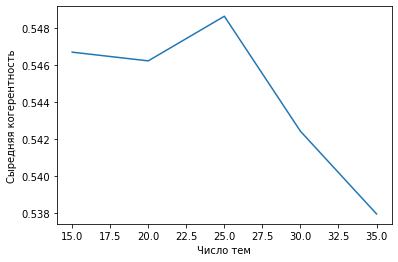

In [13]:
coherences = []

for x in tqdm(params['num_topics']):
    lda = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=x, passes=3, random_state=42)
    coherences.append(CoherenceModel(model=lda, texts=clean_texts.text, dictionary=dictionary, coherence='c_v').get_coherence())

best_num_topics = params['num_topics'][np.argmax(coherences)]

plt.plot(params['num_topics'], coherences)
plt.xlabel("Число тем")
plt.ylabel("Сыредняя когерентность")
plt.show()

100%|██████████| 8/8 [13:13<00:00, 99.18s/it] 


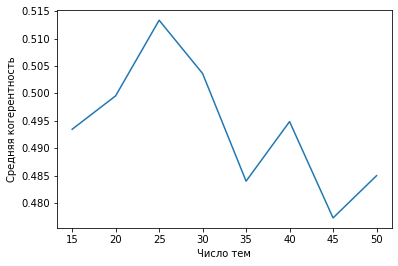

In [16]:
import matplotlib.pyplot as plt
coherences = []

for x in tqdm(params['num_topics']):
    lda = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=x, random_state=42)
    coherences.append(CoherenceModel(model=lda, texts=clean_texts.text, dictionary=dictionary, coherence='c_v').get_coherence())

best_num_topics = params['num_topics'][np.argmax(coherences)]

plt.plot(params['num_topics'], coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

100%|██████████| 7/7 [45:25<00:00, 389.30s/it]


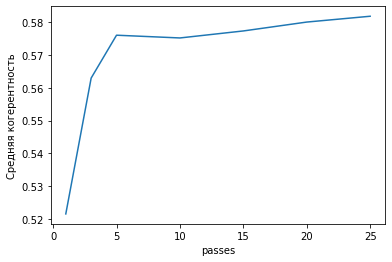

In [17]:
coherences = []

for x in tqdm(params['passes']):
    lda = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=best_num_topics, passes=x, iterations=best_iterations, random_state=42)
    coherences.append(CoherenceModel(model=lda, texts=clean_texts.text, dictionary=dictionary, coherence='c_v').get_coherence())

best_passes = params['passes'][np.argmax(coherences)]

plt.plot(params['passes'], coherences)
plt.xlabel("passes")

plt.ylabel("Средняя когерентность")
plt.show()

100%|██████████| 6/6 [16:40<00:00, 166.78s/it]


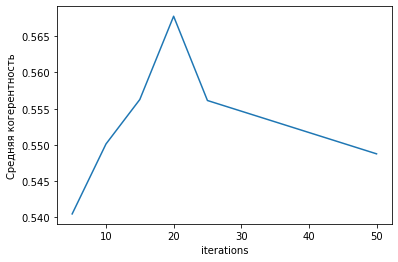

In [15]:
coherences = []

for x in tqdm(params['iterations']):
    lda = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=best_num_topics, iterations=x, passes=3, random_state=42)
    coherences.append(CoherenceModel(model=lda, texts=clean_texts.text, dictionary=dictionary, coherence='c_v').get_coherence())

best_iterations = params['iterations'][np.argmax(coherences)]
plt.plot(params['iterations'], coherences)
plt.xlabel("iterations")
plt.ylabel("Средняя когерентность")
plt.show()t

In [18]:
best_num_topics = 20
best_iterations = 10
best_passes = 25

In [17]:
lda = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=best_num_topics, iterations=10, passes=25, random_state=42)
CoherenceModel(model=lda, texts=clean_texts.text, dictionary=dictionary, coherence='c_v').get_coherence()

0.5900319928435527

In [24]:
a = CoherenceModel(model=lda, texts=clean_texts.text, dictionary=dictionary, coherence='c_v')

In [26]:
print(a.get_coherence())

100%|██████████| 6/6 [07:00<00:00, 70.09s/it]


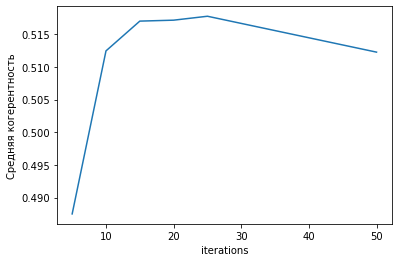

In [17]:
coherences = []

for x in tqdm(params['iterations']):
    lda = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=best_num_topics, iterations=x, random_state=42)
    coherences.append(CoherenceModel(model=lda, texts=clean_texts.text, dictionary=dictionary, coherence='c_v').get_coherence())

best_iterations = params['iterations'][np.argmax(coherences)]
plt.plot(params['iterations'], coherences)
plt.xlabel("iterations")
plt.ylabel("Средняя когерентность")
plt.show()

In [ ]:
coherences = []

for x in tqdm(params['passes']):
    lda = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=best_num_topics, iterations = best_iterations, passes=x, random_state=42)
    coherences.append(CoherenceModel(model=lda, texts=clean_texts.text, dictionary=dictionary, coherence='c_v').get_coherence())

best_passes = params['passes'][np.argmax(coherences)]

plt.plot(params['passes'], coherences)
plt.xlabel("passes")
plt.ylabel("Средняя когерентность")
plt.show()

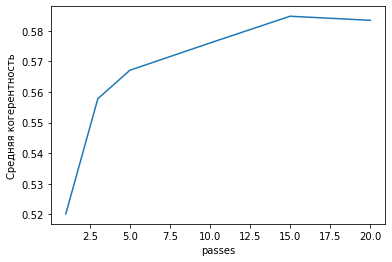

In [21]:
plt.plot(params['passes'][:-1], coherences)
plt.xlabel("passes")
plt.ylabel("Средняя когерентность")
plt.show()

100%|██████████| 4/4 [33:39<00:00, 505.00s/it]


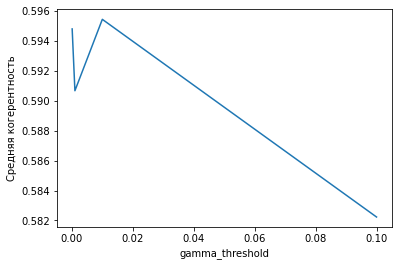

In [19]:
coherences = []

# params['gamma_threshold'] =  [0.001,0.002, 0.003, 0.004]
for x in tqdm(params['gamma_threshold']):
    lda = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=best_num_topics, iterations = best_iterations, passes=best_passes, gamma_threshold = x, random_state=42)
    coherences.append(CoherenceModel(model=lda, texts=clean_texts.text, dictionary=dictionary, coherence='c_v').get_coherence())

plt.plot(params['gamma_threshold'], coherences)
plt.xlabel("gamma_threshold")
plt.ylabel("Средняя когерентность")
plt.show()

In [ ]:
# best_num_topics = 20
# best_iterations = 10
# best_passes = 25

In [22]:
%%time
# BEST
lda = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=25, passes=5, iterations=20, random_state=42)
# lda = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=24, passes=5, iterations=20, random_state=42)
# lda = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=25, passes=15, gamma_threshold=0.1, iterations=25, random_state=42)
# previous try
# lda = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=15, passes=10, iterations=20, gamma_threshold = 0.004, random_state=42)

/home/mchelushkin/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 2min 28s, sys: 6.22 s, total: 2min 34s
Wall time: 3min 22s


In [24]:
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda, texts=clean_texts.text, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
coherence_lda

0.5919088038726381

In [26]:
lda.save('LDA/models/n25_ver2/lda.model')

/home/mchelushkin/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
lda = LdaMulticore.load('LDA/models/n25_ver2/lda.model')

In [13]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

%time vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

/home/mchelushkin/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps
/home/mchelushkin/anaconda3/lib/python3.8/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/mchelushkin/anaconda3/lib/python3.8/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


CPU times: user 33.6 s, sys: 503 ms, total: 34.1 s
Wall time: 37.6 s


In [31]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

%time vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

/home/mchelushkin/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps
/home/mchelushkin/anaconda3/lib/python3.8/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/mchelushkin/anaconda3/lib/python3.8/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


CPU times: user 14.2 s, sys: 478 ms, total: 14.7 s
Wall time: 18.5 s


## Подготовка данных для визуализации

In [6]:
def wordsCount(texts):
    count = Counter()
    for words in texts:
        for word in words:
            count[word] += 1
    return count

def removeNotCommonWords(text, word_counter):
    return [word for word in text if word_counter[word] > 10]

def func1(df):
    word_counter = wordsCount(df.text.values.tolist())
    
    df.text = df.text.apply(lambda x: removeNotCommonWords(x, word_counter))
    df.text = df.text.apply(lambda x: ' '.join(x))
    df.text = df.text.apply(lambda x: x.split())
#     df = df[df.text.apply(lambda x: len(x) >= 3)]
    df = df[df.text.apply(lambda x: len(x) >= 20 and len(x) <= 300)]
    return df

clean_texts_for_visualizarion = func1(comments_lemmatized_df)

In [7]:
clean_texts_for_visualizarion

,text,date
4,"[действительно, движение, жизнь, ребёнок, вооб...",1616477087
9,"[очень, странный, рекомендация, ношение, маска...",1616511004
13,"[переболеть, ковид, многие, слабоумный, вести,...",1616425952
24,"[переболеть, ковид, многие, слабоумный, вести,...",1616426029
27,"[эксперт, воз, установить, животное, стать, пр...",1616481257
...,...,...
1433316,"[скулить, сказать, слово, значит, сразу, скули...",1579862018
1433332,"[обычный, тактика, фарма, компания, создать, н...",1579785429
1433358,"[белый, налёт, говорить, скорее, ангина, бакте...",1579700867
1433372,"[атрибут, единорос, переходящий, красный, знам...",1579638367


In [13]:
other_corpus = [dictionary.doc2bow(text) for text in clean_texts_for_visualizarion.text]

In [16]:
topic_weights = []
topics = []
for row_list in tqdm(lda[other_corpus]):
    topic_weights.append([w for i, w in row_list])
    topics.append([i for i, w in row_list])

100%|██████████| 144155/144155 [00:49<00:00, 2883.13it/s]


In [17]:
topic_labels = list(range(1, 26))

clean_texts_for_visualizarion['topic_weights'] = topic_weights
clean_texts_for_visualizarion['topics'] = topics
clean_texts_for_visualizarion['best_topic'] = clean_texts_for_visualizarion.topic_weights.apply(lambda x: np.argmax(x))
clean_texts_for_visualizarion['formated_date'] = clean_texts_for_visualizarion.date.apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')[:10])
best_topic_weights = []
best_topic_label = []
for row in clean_texts_for_visualizarion.iterrows():
    best_topic_weights.append(row[1]['topic_weights'][row[1].best_topic])
    best_topic_label.append(topic_labels[row[1]['topics'][row[1].best_topic]])

clean_texts_for_visualizarion['best_topic_weights'] = best_topic_weights
clean_texts_for_visualizarion['best_topic_label'] = best_topic_label

In [23]:
clean_texts_for_visualizarion['text_str'] = clean_texts_for_visualizarion.text.apply(lambda x: ' '.join(x))

In [26]:
clean_texts_for_visualizarion = clean_texts_for_visualizarion.drop_duplicates(subset=['text_str'])

In [28]:
clean_texts_for_visualizarion[['date', 'formated_date', 'best_topic_weights', 'best_topic_label']].to_csv('data_for_visualization_v5.csv', index_label='id')